### Data wrangle

In [39]:
# Grab Data
from datetime import datetime as dt
import streamlit as st
import pytz
import yfinance as yf

# Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [47]:
# Collect user input for stock symbols
# user_input = input("Enter the symbols of the stocks you are interested in (comma-separated): ")
# symbols = user_input.split(",")

# Create a Portfolio
symbols = ['PFE','GSK','AZN','BMY','MRK','RHHBY','SNY','NVS','ABBV','JNJ']

In [ ]:
# Get the stock data
# tz = pytz.timezone("America/New_York")
# start = tz.localize(dt(2000,1,1))
# end = tz.localize(dt.today())

# portfolio = yf.download(symbols,start, end, auto_adjust=True)['Adj Close']
portfolio = yf.download(symbols, period = '20y')['Adj Close']
portfolio.head()

In [4]:
# SP500 ETF Benchmark
market_prices = yf.download("SPY", period = '20y')["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2000-01-03    93.591125
2000-01-04    89.931183
2000-01-05    90.091980
2000-01-06    88.644142
2000-01-07    93.792213
Name: Adj Close, dtype: float64

In [5]:
# Grap Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'PFE': 154134331392,
 'GSK': 87552614400,
 'AZN': 207138390016,
 'BMY': 105756336128,
 'MRK': 328989933568,
 'RHHBY': 201522544640,
 'SNY': 123426979840,
 'NVS': 193446232064,
 'ABBV': 313989365760,
 'JNJ': 371732643840}

### Setting up priors

In [27]:
# Compute daily returns
returns = portfolio.pct_change().dropna()

# Calculate covariance matrix
cov_matrix = returns.cov()

# Display covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
Ticker      ABBV       AZN       BMY       GSK       JNJ       MRK       NVS  \
Ticker                                                                         
ABBV    0.000277  0.000088  0.000108  0.000076  0.000082  0.000096  0.000079   
AZN     0.000088  0.000237  0.000085  0.000106  0.000066  0.000076  0.000093   
BMY     0.000108  0.000085  0.000226  0.000072  0.000076  0.000079  0.000068   
GSK     0.000076  0.000106  0.000072  0.000156  0.000063  0.000078  0.000082   
JNJ     0.000082  0.000066  0.000076  0.000063  0.000122  0.000078  0.000061   
MRK     0.000096  0.000076  0.000079  0.000078  0.000078  0.000174  0.000073   
NVS     0.000079  0.000093  0.000068  0.000082  0.000061  0.000073  0.000134   
PFE     0.000101  0.000082  0.000092  0.000074  0.000081  0.000090  0.000073   
RHHBY   0.000065  0.000092  0.000059  0.000074  0.000054  0.000061  0.000093   
SNY     0.000081  0.000104  0.000073  0.000103  0.000067  0.000076  0.000094   

Ticker       PFE    

In [26]:
# Calculate Sigma(S), the covariance matrix, using the Ledoit-Wolf method
# Ledoit-Wolf is a particular form of shrinkage, where the shrinkage coefficient is computed using O
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
print(S)

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

Ticker      ABBV       AZN       BMY       GSK       JNJ       MRK       NVS  \
Ticker                                                                         
ABBV    0.032430  0.010229  0.012578  0.008759  0.009526  0.011133  0.009153   
AZN     0.010229  0.071797  0.026671  0.036393  0.020033  0.027931  0.027263   
BMY     0.012578  0.026671  0.073394  0.024760  0.022963  0.033559  0.019395   
GSK     0.008759  0.036393  0.024760  0.053042  0.020447  0.027709  0.025034   
JNJ     0.009526  0.020033  0.022963  0.020447  0.037040  0.026171  0.016292   
MRK     0.011133  0.027931  0.033559  0.027709  0.026171  0.069185  0.022123   
NVS     0.009153  0.027263  0.019395  0.025034  0.016292  0.022123  0.041849   
PFE     0.011715  0.027920  0.032180  0.026947  0.025734  0.035719  0.022405   
RHHBY   0.007516  0.022300  0.014665  0.019175  0.012423  0.016581  0.022865   
SNY     0.009349  0.031934  0.023880  0.030143  0.019085  0.025660  0.026997   

Ticker       PFE     RHHBY       SNY  


1.8014987287880029

<Axes: xlabel='Ticker', ylabel='Ticker'>

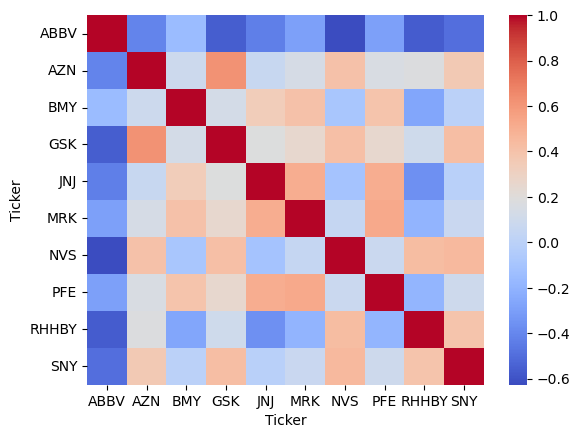

In [7]:
# Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

In [8]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
ABBV     0.044030
AZN      0.070687
BMY      0.066248
GSK      0.063878
JNJ      0.059449
MRK      0.075261
NVS      0.059338
PFE      0.069411
RHHBY    0.054033
SNY      0.065440
dtype: float64

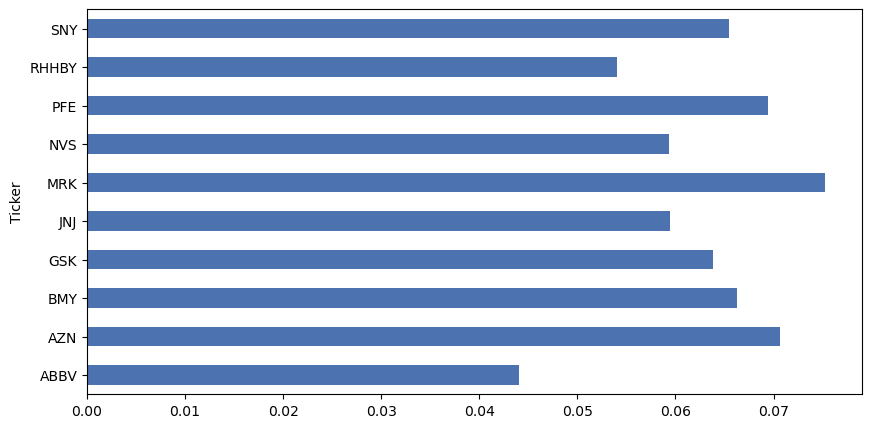

In [9]:
# What am I looking at here?
market_prior.plot.barh(figsize=(10,5))

### Integrating views

In [10]:
# You don't have to provide views on all the assets
viewdict = {'PFE': 0.1,
            'GSK': 0.1,
            'AZN': -0.05,
            'BMY': 0.28,
            'MRK': 0.09,
            'RHHBY': -0.12,
            'SNY': 0.07,
            'NVS': -0.25,
            'ABBV': 0.21,
            'JNJ': 0.2}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

#### Creating confidences

We can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [11]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.03, 0.1),
    (-0.1, 0),
    (0.1, 0.2),
    (-0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [12]:
variances = []
for lb, ub in intervals: # lb: lower bound, ub: upper bound
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0012250000000000002, 0.0025000000000000005, 0.0025000000000000005, 0.010000000000000002, 0.16000000000000003, 0.0225]


### Calculate Posterior Estimate Returns

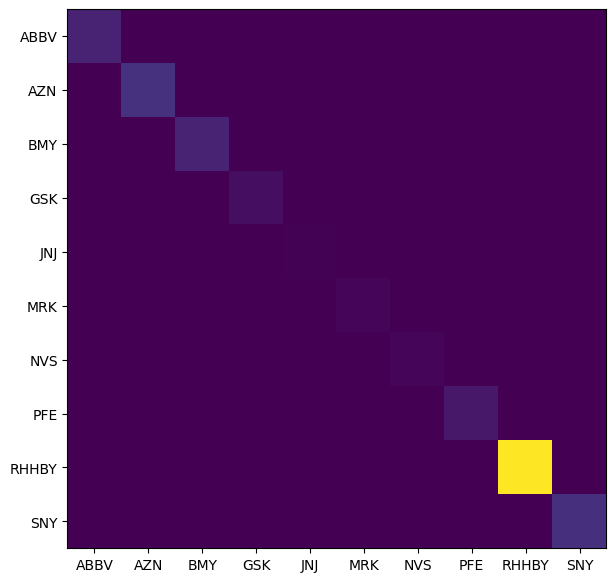

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [14]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [15]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
ABBV     0.028810
AZN      0.033187
BMY      0.125334
GSK      0.042520
JNJ      0.057520
MRK      0.083923
NVS     -0.002602
PFE      0.069711
RHHBY   -0.031997
SNY      0.043832
dtype: float64

In [16]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
ABBV,0.044030,0.028810,0.21
AZN,0.070687,0.033187,-0.05
BMY,0.066248,0.125334,0.28
GSK,0.063878,0.042520,0.10
JNJ,0.059449,0.057520,0.20
MRK,0.075261,0.083923,0.09
NVS,0.059338,-0.002602,-0.25
PFE,0.069411,0.069711,0.10
RHHBY,0.054033,-0.031997,-0.12
SNY,0.065440,0.043832,0.07


<Axes: >

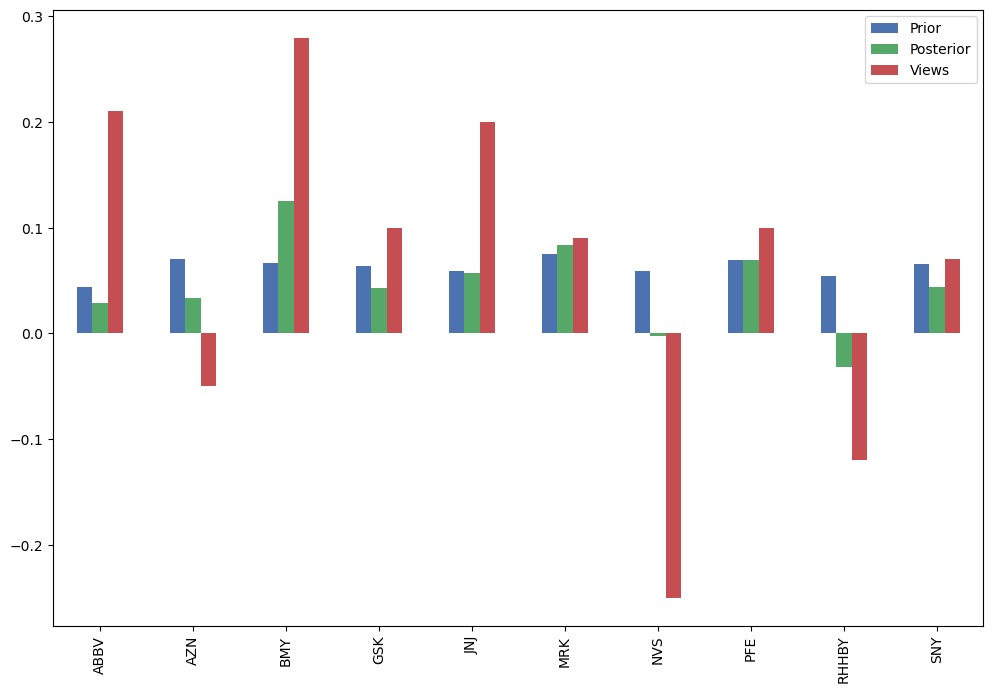

In [17]:
rets_df.plot.bar(figsize=(12,8))

Ticker      ABBV       AZN       BMY       GSK       JNJ       MRK       NVS  \
Ticker                                                                         
ABBV    0.033914  0.010387  0.012798  0.008875  0.009738  0.011219  0.009319   
AZN     0.010387  0.074072  0.026980  0.037169  0.020309  0.028106  0.027726   
BMY     0.012798  0.026980  0.075290  0.025046  0.023286  0.033785  0.019580   
GSK     0.008875  0.037169  0.025046  0.054715  0.020786  0.027907  0.025472   
JNJ     0.009738  0.020309  0.023286  0.020786  0.038288  0.026402  0.016523   
MRK     0.011219  0.028106  0.033785  0.027907  0.026402  0.070029  0.022259   
NVS     0.009319  0.027726  0.019580  0.025472  0.016523  0.022259  0.043104   
PFE     0.011931  0.028302  0.032627  0.027346  0.026220  0.036019  0.022713   
RHHBY   0.007615  0.022562  0.014749  0.019382  0.012533  0.016643  0.023208   
SNY     0.009437  0.032293  0.024048  0.030507  0.019264  0.025762  0.027306   

Ticker       PFE     RHHBY       SNY  


<Axes: >

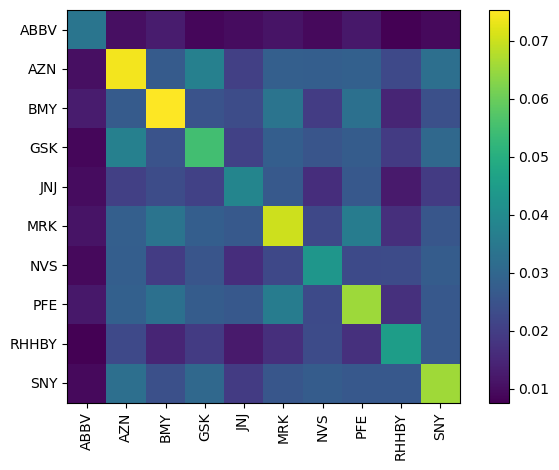

In [50]:
S_bl = bl.bl_cov()
print(S_bl)
plotting.plot_covariance(S_bl)

### Portfolio allocation

In [19]:
ef = EfficientFrontier(ret_bl, S_bl)

# A regularization term added to the optimization objective to improve the stability and robustness 
# of the optimized portfolio by penalizing extreme portfolio weights
ef.add_objective(objective_functions.L2_reg)

ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('ABBV', 0.02172),
             ('AZN', 0.02214),
             ('BMY', 0.35701),
             ('GSK', 0.05856),
             ('JNJ', 0.11797),
             ('MRK', 0.20502),
             ('NVS', 0.0),
             ('PFE', 0.1536),
             ('RHHBY', 0.0),
             ('SNY', 0.06398)])

<Axes: >

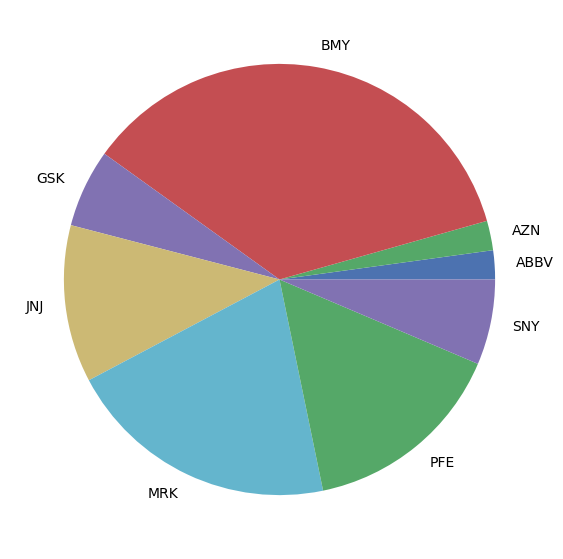

In [20]:
pd.Series(weights).plot.pie(figsize=(7,7))

c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 8.6%
Annual volatility: 19.3%
Sharpe Ratio: 0.34


c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.0860995875263826, 0.19252638928824256, 0.3433274148585471)

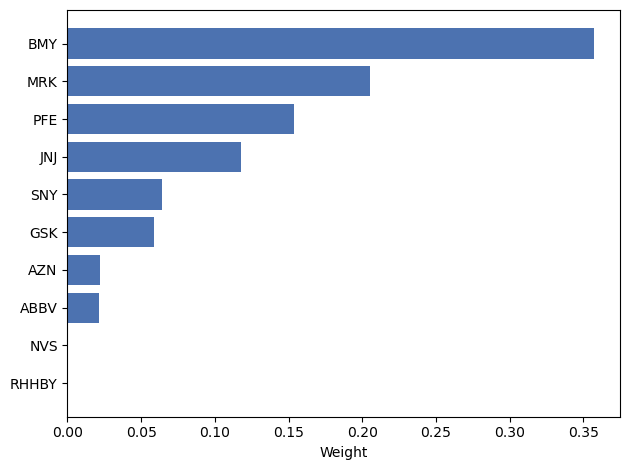

In [21]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

In [22]:
import torch

In [54]:
# Extract the posterior estimate returns from the Black-Litterman model
exp_returns = ret_bl.values
cov_matrix = S_bl.values

# Convert the posterior returns to a torch tensor
exp_returns_tensor = torch.Tensor(exp_returns).float()
cov_matrix_tensor = torch.Tensor(cov_matrix).float()

In [ ]:
# May revise pricing_model.py by adding the following
from pricing_model import neuralized_heston
class neuralized_heston(nn.Module):
    def __init__(self, device='cpu'):
        super(neuralized_heston, self).__init__()
        self.heston = heston()
        self.param_LSTM = param_LSTM(device)
        self.device = device
        self.to(device)
    
    def forward(self, params, exp_returns, cov_matrix):
        # Forward propagation
        # params: Other parameters needed for calculations
        # exp_returns: Expected returns obtained from Black-Litterman
        # cov_matrix: Covariance matrix obtained from Black-Litterman

        # Pass params through LSTM model to obtain processed parameters
        processed_params = self.param_LSTM(params)

        # Integrate processed parameters, expected returns, and covariance matrix into Heston model
        # Here you can modify the heston_predictions function to incorporate the additional inputs
        heston_output = self.heston(processed_params, exp_returns, cov_matrix)
        return heston_output